# Premature Optimization is the root of all evil

For 33x33, moves don't change the majority of the permutation (over 99% unchanged). How can we take advantage of this?

In [2]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from numba import jit
import pstats
import heapq
import time
import cProfile
import pandas as pd
import json

In [3]:
def getInversePerm(arr):
    # gets the inverse move for a certain move
    res = [0 for i in range(len(arr))]
    for i in range(len(arr)):
        res[arr[i]] = i
    return res


def describe_array(arr):
    print("Array:", arr)
    print("Count:", len(arr))
    print("Mean:", np.mean(arr))
    print("Median:", np.median(arr))
    print("Standard Deviation:", np.std(arr))
    print("Variance:", np.var(arr))
    print("Minimum:", np.min(arr))
    print("Maximum:", np.max(arr))
    print("Range:", np.max(arr) - np.min(arr))
    print("25th Percentile:", np.percentile(arr, 25))
    print("50th Percentile (Median):", np.percentile(arr, 50))
    print("75th Percentile:", np.percentile(arr, 75))
    print("Interquartile Range:", np.percentile(arr, 75) - np.percentile(arr, 25))

In [4]:
# File paths
puzzle_info_path = 'puzzle_info.csv'
puzzles_path = 'puzzles.csv'
sample_submission_path = 'sample_submission.csv' # change name across board
my_submission_path = 'submission.csv'

# Loading the data
puzzle_info_df = pd.read_csv(puzzle_info_path)
puzzles_df = pd.read_csv(puzzles_path)
sample_submission_df = pd.read_csv(sample_submission_path)
my_submission_df = pd.read_csv(my_submission_path)
puzzles_df.head()

,id,puzzle_type,solution_state,initial_state,num_wildcards
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0


In [5]:
# Parsing the initial_state and solution_state columns
# Converting the semicolon-separated string values into lists of colors
puzzles_df['parsed_initial_state'] = puzzles_df['initial_state'].apply(lambda x: x.split(';'))
seen = {}

for i in range(len(puzzles_df['parsed_initial_state'])):
    for j in range(len(puzzles_df['parsed_initial_state'][i])):
        if puzzles_df['parsed_initial_state'][i][j] not in seen:
            seen[puzzles_df['parsed_initial_state'][i][j]] = len(seen)
        puzzles_df['parsed_initial_state'][i][j] = seen[puzzles_df['parsed_initial_state'][i][j]]

puzzles_df['parsed_solution_state'] = puzzles_df['solution_state'].apply(lambda x: x.split(';'))

for i in range(len(puzzles_df['parsed_solution_state'])):
    for j in range(len(puzzles_df['parsed_solution_state'][i])):
        puzzles_df['parsed_solution_state'][i][j] = seen[puzzles_df['parsed_solution_state'][i][j]]

# Displaying the modified dataframe with parsed states
puzzles_df[['id', 'puzzle_type', 'parsed_initial_state', 'parsed_solution_state']].head()

,id,puzzle_type,parsed_initial_state,parsed_solution_state
0,0,cube_2/2/2,"[0, 1, 0, 2, 1, 3, 2, 3, 4, 2, 4, 2, 0, 4, 0, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
1,1,cube_2/2/2,"[0, 1, 4, 3, 3, 1, 5, 2, 5, 0, 3, 5, 5, 1, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
2,2,cube_2/2/2,"[1, 5, 4, 4, 5, 2, 0, 0, 3, 3, 2, 5, 1, 3, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
3,3,cube_2/2/2,"[2, 4, 1, 4, 5, 0, 1, 0, 2, 2, 5, 2, 3, 0, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
4,4,cube_2/2/2,"[1, 0, 1, 0, 2, 1, 5, 3, 2, 4, 5, 0, 5, 0, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."


In [6]:
# Converting the string representation of allowed_moves to dictionary
puzzle_info_df['allowed_moves'] = puzzle_info_df['allowed_moves'].apply(lambda x: json.loads(x.replace("'", '"')))

# Selecting an example puzzle type and displaying its allowed moves
example_puzzle_type = puzzle_info_df['puzzle_type'].iloc[0]
example_allowed_moves = puzzle_info_df[puzzle_info_df['puzzle_type'] == example_puzzle_type]['allowed_moves'].iloc[0]

In [7]:
# type : (np.array(move_perm_i), np.array(name_i))
puz_info = {}

# type : {move : perm}
move_to_perm = {}

for i in range(len(puzzle_info_df)):
    puz_info[puzzle_info_df['puzzle_type'][i]] = [[], []]
    move_to_perm[puzzle_info_df['puzzle_type'][i]] = {}
    
    for j in puzzle_info_df['allowed_moves'][i].keys():
        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(j)
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(puzzle_info_df['allowed_moves'][i][j]))

        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(str('-' + j)) # might be the opposite
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j])))

        move_to_perm[puzzle_info_df['puzzle_type'][i]][str('-' + j)] = np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j]))
        move_to_perm[puzzle_info_df['puzzle_type'][i]][j] = np.array(puzzle_info_df['allowed_moves'][i][j])

# move_to_perm['cube_2/2/2']

In [8]:
# optimize reference solution
reference_solution = pd.read_csv(sample_submission_path)
reference_solution

,id,moves
0,0,r1.-f1
1,1,f1.d0.-r0.-f1.-d0.-f1.d0.-r0.f0.-f1.-r0.f1.-d1...
2,2,f1.d0.-d1.r0.-d1.-f0.f1.-r0.-f0.-r1.-f0.r0.-d0...
3,3,-f0.-r0.-f0.-d0.-f0.f1.r0.-d1.-r0.-r1.-r0.-f1....
4,4,d1.-f1.d1.r1.-f0.d1.-d0.-r1.d1.d1.-f1.d1.-d0.-...
...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...


# Submission Stats

In [9]:
tot = 0
arr = []
for i in range(len(sample_submission_df)):
    arr.append(len(sample_submission_df['moves'][i].split('.')))
    tot += len(sample_submission_df['moves'][i].split('.'))

describe_array(arr)
print("Score:", tot)

Array: [2, 63, 62, 92, 70, 54, 68, 83, 98, 76, 66, 63, 72, 131, 96, 68, 63, 62, 89, 82, 112, 96, 63, 53, 99, 61, 93, 73, 83, 82, 300, 392, 268, 239, 304, 440, 267, 299, 237, 408, 259, 296, 208, 229, 602, 584, 327, 358, 242, 258, 238, 370, 479, 355, 230, 309, 285, 344, 282, 415, 251, 236, 385, 225, 429, 200, 250, 331, 298, 225, 205, 266, 327, 392, 408, 320, 382, 358, 257, 254, 372, 221, 251, 300, 260, 227, 265, 310, 209, 268, 277, 303, 216, 214, 317, 287, 425, 323, 292, 249, 263, 356, 274, 398, 221, 231, 207, 340, 342, 268, 257, 265, 399, 219, 262, 273, 329, 315, 385, 360, 331, 295, 339, 346, 301, 311, 268, 264, 260, 299, 362, 401, 215, 268, 395, 372, 227, 376, 257, 241, 209, 287, 412, 474, 399, 267, 358, 263, 233, 258, 700, 610, 498, 593, 665, 544, 642, 637, 443, 697, 598, 538, 789, 816, 542, 616, 597, 465, 420, 670, 558, 519, 466, 736, 483, 472, 737, 493, 534, 486, 670, 592, 491, 675, 499, 888, 595, 734, 701, 451, 458, 731, 737, 659, 495, 594, 947, 550, 422, 517, 623, 633, 439, 586, 5

In [10]:
print("## MY SUBMISSION INFO ##")

tot = 0
arr = []
for i in range(len(my_submission_df)):
    arr.append(len(my_submission_df['moves'][i].split('.')))
    tot += len(my_submission_df['moves'][i].split('.'))

describe_array(arr)
print()
print("Score:", tot)

## MY SUBMISSION INFO ##
Array: [2, 9, 12, 10, 12, 12, 12, 11, 12, 12, 10, 11, 12, 11, 12, 10, 11, 12, 11, 12, 12, 14, 13, 11, 11, 13, 13, 13, 13, 10, 300, 392, 268, 239, 304, 440, 267, 299, 237, 408, 259, 296, 208, 229, 602, 584, 327, 358, 242, 258, 238, 370, 479, 355, 230, 309, 285, 344, 282, 415, 251, 236, 385, 225, 429, 200, 250, 331, 298, 225, 205, 266, 327, 392, 408, 320, 382, 358, 257, 254, 372, 221, 251, 300, 260, 227, 265, 310, 209, 268, 277, 303, 216, 214, 317, 287, 425, 323, 292, 249, 263, 356, 274, 398, 221, 231, 207, 340, 342, 268, 257, 265, 399, 219, 262, 273, 329, 315, 385, 360, 331, 295, 339, 346, 301, 311, 268, 264, 260, 299, 362, 401, 215, 268, 395, 372, 227, 376, 257, 241, 209, 287, 412, 474, 399, 267, 358, 263, 233, 258, 700, 610, 498, 593, 665, 544, 642, 637, 443, 697, 598, 538, 789, 816, 542, 616, 597, 465, 420, 670, 558, 519, 466, 736, 483, 472, 737, 493, 534, 486, 670, 592, 491, 675, 499, 888, 595, 734, 701, 451, 458, 731, 737, 659, 495, 594, 947, 550, 422, 517,

# Puzzle Type Stats

type : nodes : degree : # of times puzzle is in puzzles

In [11]:
# type : (np.array(move_perm_i), np.array(name_i))
puz_info

for i in puz_info.keys():
    print(i, '-->', len(puz_info[i][0][0]), len(puz_info[i][0]), len(puzzles_df[puzzles_df['puzzle_type'] == i]))
    # print("Nodes:", len(puz_info[i][0][0]))
    # print("Degree:", len(puz_info[i][0]))

# type : {move : perm}
# move_to_perm

cube_2/2/2 --> 24 12 30
cube_3/3/3 --> 54 18 120
cube_4/4/4 --> 96 24 60
cube_5/5/5 --> 150 30 35
cube_6/6/6 --> 216 36 12
cube_7/7/7 --> 294 42 5
cube_8/8/8 --> 384 48 5
cube_9/9/9 --> 486 54 5
cube_10/10/10 --> 600 60 5
cube_19/19/19 --> 2166 114 4
cube_33/33/33 --> 6534 198 3
wreath_6/6 --> 10 4 20
wreath_7/7 --> 12 4 15
wreath_12/12 --> 22 4 10
wreath_21/21 --> 40 4 5
wreath_33/33 --> 64 4 3
wreath_100/100 --> 198 4 1
globe_1/8 --> 32 36 10
globe_1/16 --> 64 68 5
globe_2/6 --> 36 30 5
globe_3/4 --> 32 24 15
globe_6/4 --> 56 30 5
globe_6/8 --> 112 46 5
globe_6/10 --> 140 54 5
globe_3/33 --> 264 140 4
globe_33/3 --> 264 140 4
globe_8/25 --> 450 118 2


In [14]:
puzzles_df[puzzles_df['puzzle_type'] == 'wreath_12/12'].head(3)

,id,puzzle_type,solution_state,initial_state,num_wildcards,parsed_initial_state,parsed_solution_state
319,319,wreath_12/12,C;A;A;C;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;B,A;B;A;B;B;B;B;A;A;B;B;A;B;B;A;B;C;C;A;A;A;A,2,"[2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, ...","[4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, ..."
320,320,wreath_12/12,C;A;A;C;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;B,A;A;C;B;B;C;A;B;A;B;A;A;B;B;A;B;A;B;B;B;A;A,0,"[2, 2, 4, 3, 3, 4, 2, 3, 2, 3, 2, 2, 3, 3, 2, ...","[4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, ..."
321,321,wreath_12/12,C;A;A;C;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;B,B;B;C;B;A;A;A;B;B;B;A;B;A;A;C;A;B;B;B;A;A;A,2,"[3, 3, 4, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 4, ...","[4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, ..."


In [13]:
puzzles_df[puzzles_df['puzzle_type'] == 'cube_3/3/3'].head(1)

,id,puzzle_type,solution_state,initial_state,num_wildcards,parsed_initial_state,parsed_solution_state
30,30,cube_3/3/3,A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;...,A;A;E;C;F;F;C;C;C;D;B;D;D;B;A;B;F;F;A;E;B;D;E;...,0,"[2, 2, 1, 4, 5, 5, 4, 4, 4, 0, 3, 0, 0, 3, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, ..."


In [87]:
puzzles_df[puzzles_df['puzzle_type'] == 'globe_1/8'].head(1)

,id,puzzle_type,solution_state,initial_state,num_wildcards,parsed_initial_state,parsed_solution_state
338,338,globe_1/8,A;A;C;C;E;E;G;G;I;I;K;K;M;M;O;O;B;B;D;D;F;F;H;...,I;P;O;A;A;D;F;L;J;M;G;M;P;F;E;J;E;B;O;G;H;D;N;...,0,"[6540, 6541, 6542, 2, 2, 0, 5, 6543, 6544, 654...","[2, 2, 4, 4, 1, 1, 6546, 6546, 6540, 6540, 654..."


# A* Stats

In [17]:
@jit(nopython=True, parallel = True, fastmath = True)
def hash_perm(perm):
    base = 9973
    modb = 1000000007
    modc = 1000000009

    B, C = 0, 0
    for i in perm:
        B = (B * base) % modb + i
        C = (C * base) % modc + i

    return (B, C)

def dist(a, b):
    return np.count_nonzero(a != b)

In [18]:
# 1e6 ~ 2 seconds
mx_mem = int(1e7)
mem_idx = 0

last_state = np.zeros(mx_mem, dtype=int)
last_move = np.zeros(mx_mem, dtype=int)

print(last_state)

[0 0 0 ... 0 0 0]


In [58]:
pq = []
def a_star_search(idx):
    global mem_idx
    global pq

    test = 0
    initial_state = np.array(puzzles_df['parsed_initial_state'][idx])
    goal_state = np.array(puzzles_df['parsed_solution_state'][idx])
    max_dist = puzzles_df['num_wildcards'][idx]
    move_perm = np.array(puz_info[puzzles_df['puzzle_type'][idx]][0])

    n = len(initial_state)
    m = len(move_perm)
    
    heapq.heappush(pq, (0, mem_idx, initial_state, 0))  # (priority, mem_idx, state, path_length)
    mem_idx += 1
    
    considered = set()
    considered.add(hash_perm(initial_state))

    while mem_idx + m < mx_mem:
        _, cur_idx, cur_state, cur_p = heapq.heappop(pq) 

        test_edge_reduce = []
        for i in range(m):
            nxt_state = cur_state[move_perm[i]]
            nxt_hash = hash_perm(nxt_state)
            
            if nxt_hash in considered:
                test += 1
                continue
            
            considered.add(nxt_hash)
            nxt_dist = dist(nxt_state, goal_state)
            test_edge_reduce.append(nxt_dist)
            last_state[mem_idx] = cur_idx
            last_move[mem_idx] = i

            if nxt_dist <= max_dist:
                print("Percentage of times next_hash is in considered", test / (mem_idx + test))
                return mem_idx

            # add logic for if nxt_dist is too large, skip
            
            priority = 1+cur_p + nxt_dist
            heapq.heappush(pq, (priority, mem_idx, nxt_state, 1+cur_p))
            mem_idx += 1
        
        print("Distribution of dist of children nodes", test_edge_reduce)
        break
    return None

def dig_through_memory(idx):
    res = []
    while idx != 0:
        res.append(last_move[idx])
        idx = last_state[idx]

    res = list(reversed(res))
    return res

def solve(idx):
    global mem_idx
    global pq
    
    mem_idx = 0
    
    move_name = np.array(puz_info[puzzles_df['puzzle_type'][idx]][1])

    pq = []
    res = a_star_search(idx)
    
    if res == None:
        return sample_submission_df['moves'][idx]

    res = dig_through_memory(res)
    for i in range(len(res)):
        res[i] = move_name[res[i]]

    return res

solve(280)

Distribution of dist of children nodes [1820, 1818, 1820, 1808, 1823, 1821, 1827, 1826, 1816, 1818, 1823, 1828, 1813, 1816, 1814, 1816, 1822, 1819, 1812, 1819, 1827, 1819, 1822, 1822, 1814, 1823, 1823, 1819, 1823, 1825, 1824, 1825, 1827, 1820, 1816, 1818, 1813, 1816, 1823, 1821, 1820, 1823, 1813, 1812, 1818, 1814, 1821, 1821, 1810, 1817, 1828, 1819, 1823, 1824, 1831, 1826, 1821, 1814, 1821, 1812, 1815, 1817, 1817, 1812, 1821, 1824, 1822, 1821, 1813, 1822, 1818, 1826, 1815, 1816, 1820, 1818, 1820, 1821, 1816, 1819, 1811, 1816, 1823, 1819, 1823, 1818, 1817, 1821, 1826, 1827, 1820, 1813, 1820, 1818, 1830, 1824, 1823, 1827, 1822, 1821, 1813, 1819, 1812, 1818, 1818, 1821, 1816, 1824, 1817, 1818, 1817, 1817, 1819, 1811]


'-r11.-r16.-d5.f16.r9.-d8.-d14.-r17.f6.r6.d0.-r18.-f13.-f18.-f13.-r8.-d3.f2.d15.-d5.r1.f6.-f14.r14.r10.r2.-r4.-f15.d14.-d17.r2.f17.r3.r3.r1.f6.f12.-f3.f9.r3.r1.f6.f15.f15.r0.r16.-r14.d1.d4.-r0.-f17.r6.-r16.-r0.r9.-d8.-d14.-r17.f6.-f2.-f3.-f6.-r1.-f12.d4.-d2.-r4.-r14.f14.d17.-r16.-f10.d14.-r13.f14.f4.-f10.-f16.d5.r16.r11.-f3.-f6.-r1.-f12.r6.-f7.-d6.-r10.r11.f4.-f10.-r11.-r16.-d5.f16.r16.-f5.-f6.-r1.-r3.-d2.-r4.f18.-r3.-f17.-f3.f9.r4.-f3.-f6.-r1.r4.-f3.-f6.-r1.-f7.-f14.r14.f6.d13.r15.-f14.r14.-d14.f10.d3.f11.f1.d5.-r13.-f1.f6.d13.r15.-f14.r14.d10.-f17.-f12.-d0.r13.-d14.f10.f8.-r16.-r0.-f15.-f15.-f6.-r1.-r3.-f9.f3.-f12.-f6.-r1.-r3.-r3.-f17.-r2.d17.-d14.f15.r4.-r2.-r10.-r14.f14.-f11.-r11.-r16.f3.-d0.-r11.-f9.f3.r17.-f7.r4.-r2.-r10.-r14.f14.-f15.-f6.-r1.-r3.-f9.f3.-f12.-f6.-r1.-r3.f9.r10.-r16.-r0.-f15.f7.-r17.-f3.f9.r11.d0.-f3.r16.r13.-d14.f10.-f7.-r18.f6.d13.d8.-r9.-d5.-f8.r12.-r6.-r0.-f17.r18.-d0.-r6.-f6.r17.d14.d8.-r9.-r11.-r16.f3.-d0.-r11.-f9.f3.r17.-f7.f15.r0.r16.-r10.-f9.-r16.-r0.-f15

## Wreath

Dist overtime --> Roughly linear

Percentage of times next hash is in considered 0.3007160667476504
319  -->  ['l', '-r', '-r', 'l', '-r', 'l', 'r', 'l', 'l', 'l', 'r', 'l', 'r', 'r', 'r', 'r', '-l', '-l']


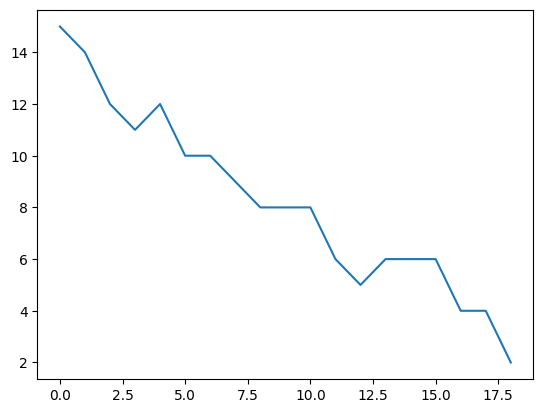

Percentage of times next hash is in considered 0.3063348316099462
320  -->  ['l', 'l', 'l', 'l', 'r', 'l', 'l', 'r', '-l', '-l', 'r', '-l', 'r', 'r', '-l']


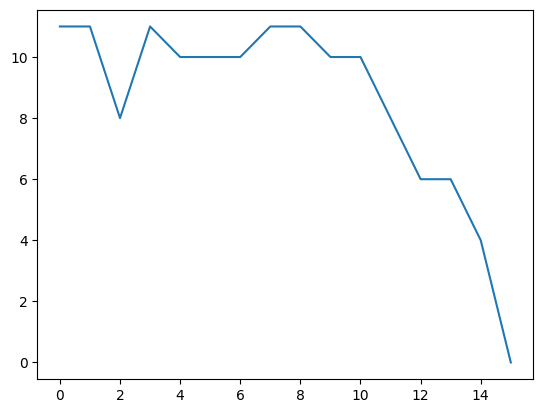

Percentage of times next hash is in considered 0.2971656261594799
321  -->  ['-l', '-l', 'r', '-l', 'r', '-l', 'r', 'r', '-l', '-l', '-l', '-r', '-l', 'r', '-l', '-l']


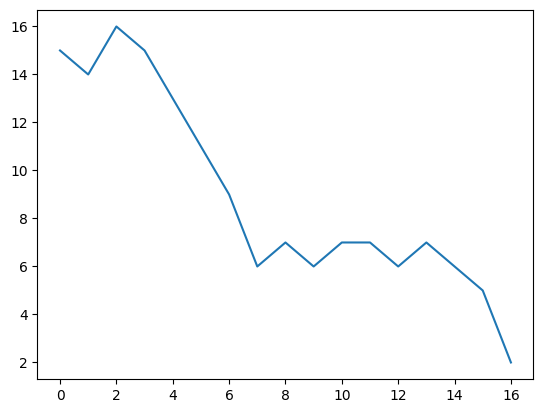

CPU times: user 1.68 s, sys: 34.1 ms, total: 1.72 s
Wall time: 803 ms


In [45]:
%%time
for i in range(319, 322):
    a = solve(i)
    print(i, " --> ", a)
    xs = [i for i in range(len(a) + 1)]
    ys = []

    goal = np.array(puzzles_df['parsed_solution_state'][i])
    cur = np.array(puzzles_df['parsed_initial_state'][i])
    ys.append(dist(cur, goal))

    for j in a:
        b = move_to_perm[puzzles_df['puzzle_type'][i]][j]
        cur = cur[b]
        ys.append(dist(cur, goal))
    
    plt.plot(xs, ys)
    plt.show()

## Cube

Dist overtime --> Less linear than wreath

0.18969854378848455
15  -->  ['f0', '-f1', 'd0', 'f0', 'd0', '-r0', '-f1', '-d0', '-f1', 'r0']


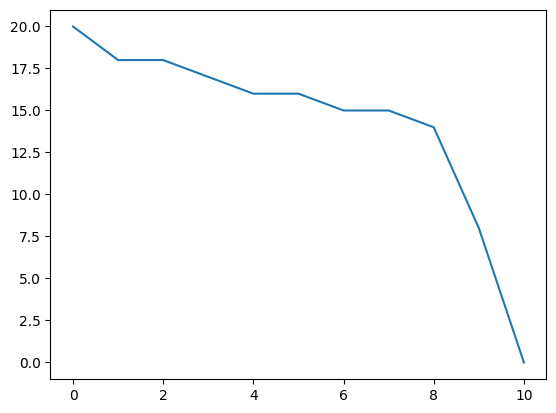

0.18508040500297795
16  -->  ['-f0', '-d0', '-f1', '-r0', '-f1', '-r0', 'd1', 'f1', 'r0', '-f1', '-r0']


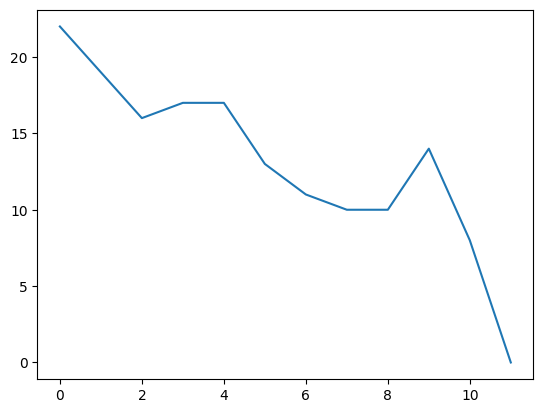

0.2739956943823876
17  -->  ['d0', 'f1', 'd1', 'f1', '-d1', 'f1', '-d1', '-r0', '-r0', 'd1', 'd1', 'r0']


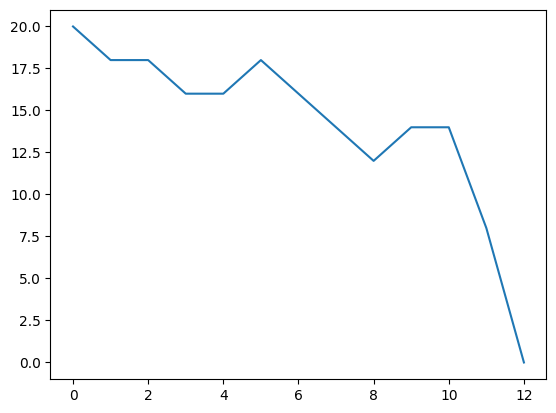

CPU times: user 4.97 s, sys: 81.4 ms, total: 5.05 s
Wall time: 3.89 s


In [42]:
%%time
for i in range(15, 18):
    a = solve(i)
    print(i, " --> ", a)
    xs = [i for i in range(len(a) + 1)]
    ys = []

    goal = np.array(puzzles_df['parsed_solution_state'][i])
    cur = np.array(puzzles_df['parsed_initial_state'][i])
    ys.append(dist(cur, goal))

    for j in a:
        b = move_to_perm[puzzles_df['puzzle_type'][i]][j]
        cur = cur[b]
        ys.append(dist(cur, goal))
    
    plt.plot(xs, ys)
    plt.show()

length:  6   r1.-f1


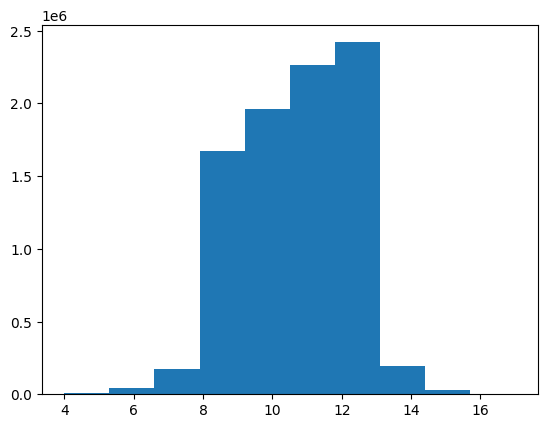

0.16038382453735436
length:  9   ['f0', 'r1', 'f1', '-d0', '-d0', 'f1', '-d0', '-f1', 'd0']


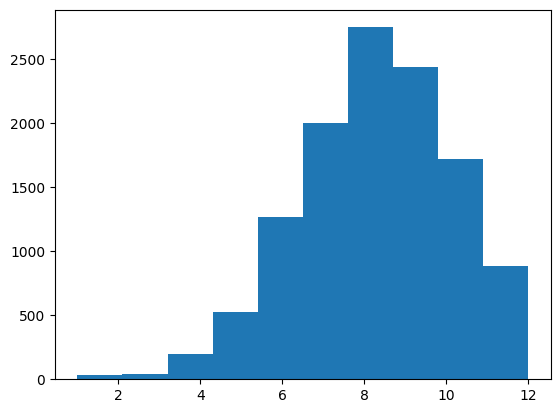

0.2297003896762828
length:  12   ['-f1', '-r0', '-f0', '-r1', '-f0', 'd0', '-r1', '-d0', 'f0', 'd0', 'd0', '-f0']


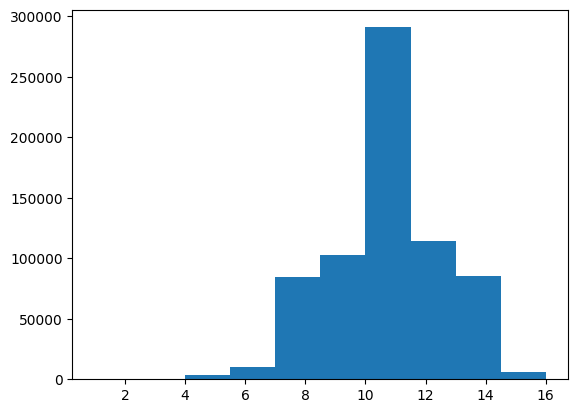

0.21860358170023333
length:  10   ['-f0', 'd0', '-r0', 'f0', '-d0', '-r0', 'd0', '-f0', '-r0', '-f0']


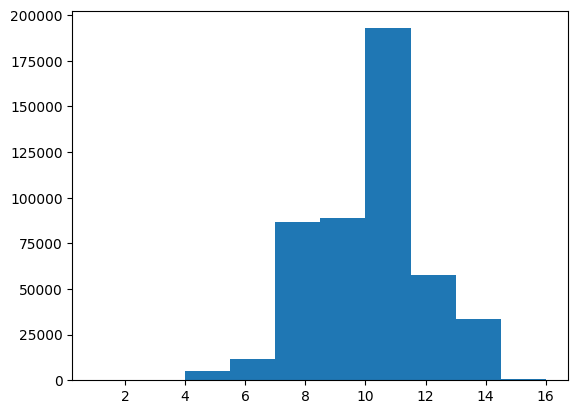

0.21435954609877858
length:  12   ['f0', '-r0', '-f1', '-r0', '-d1', '-r0', '-d1', '-d1', 'r0', 'd0', 'f1', '-d0']


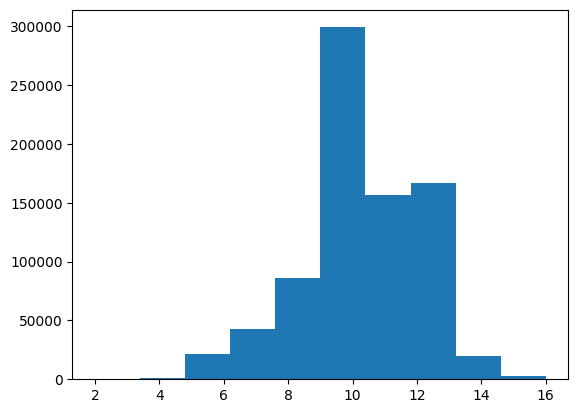

0.26956381931005485
length:  12   ['f0', '-r0', '-f0', '-r0', '-f0', '-f0', '-d1', '-f0', '-d1', '-r0', '-f0', 'r0']


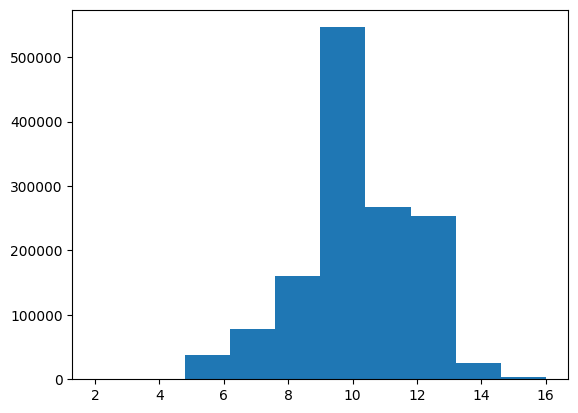

0.21430616641085656
length:  12   ['-r0', 'r1', 'f0', '-r1', 'd1', 'f1', '-d0', 'f0', '-d0', 'f0', 'd0', 'd0']


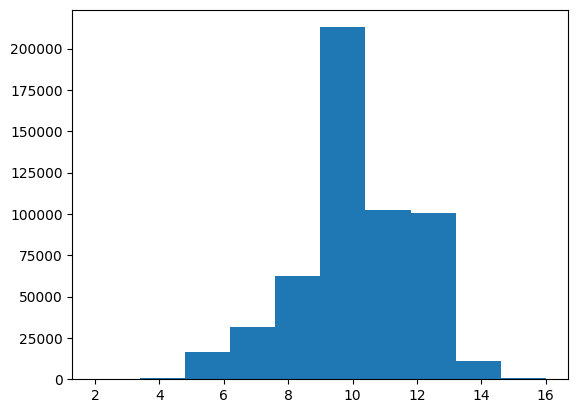

0.2131747084462567
length:  11   ['-f1', '-r0', '-f0', '-d0', '-f1', '-r1', 'd1', '-r1', 'f0', '-d1', '-f0']


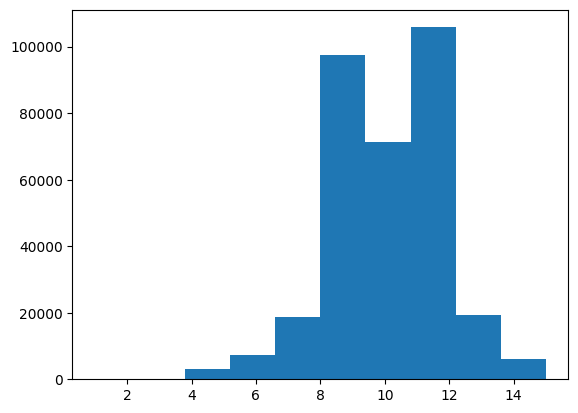

0.2492811366164461
length:  12   ['-d0', '-f0', '-r1', '-d1', '-f0', '-r0', 'f0', 'f0', 'r0', '-f0', '-d1', 'f0']


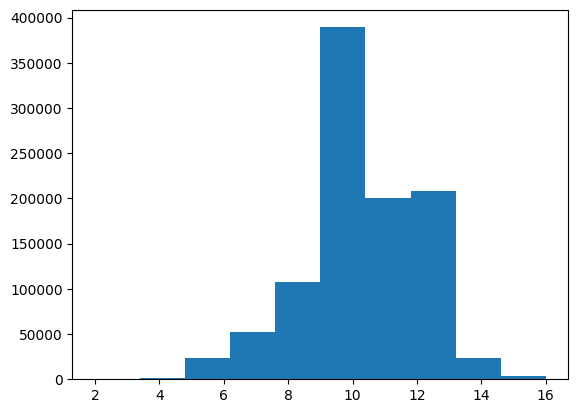

0.23241503023391188
length:  12   ['-d1', 'f1', '-f0', '-r0', 'd0', 'd0', '-r0', '-d0', '-r0', '-f0', 'r0', 'f0']


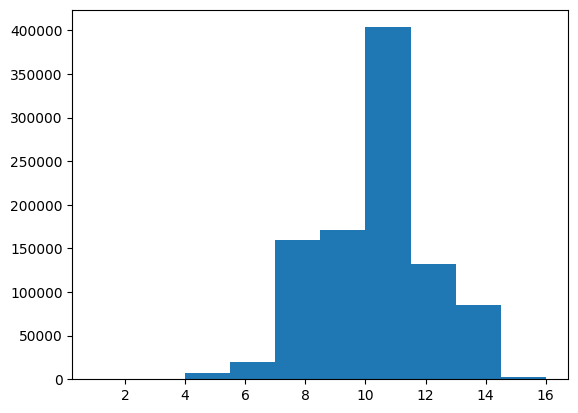

0.18391587229535483
length:  10   ['f0', 'd1', '-r0', 'r1', 'f0', 'd1', '-f0', '-d1', '-d1', '-f0']


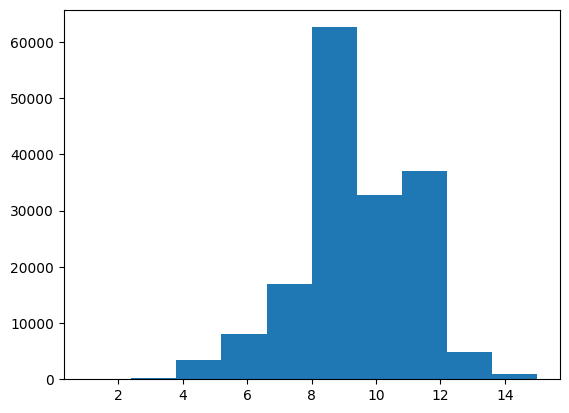

0.21235772737695507
length:  11   ['d0', '-f1', '-d1', 'f0', 'r1', '-d1', 'r0', '-f1', '-d1', '-f1', '-d1']


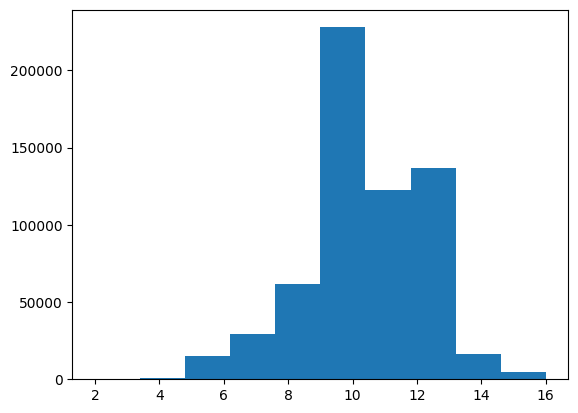

0.2640190041442274
length:  12   ['r0', '-r1', 'd1', '-r1', '-f1', '-f1', 'd1', '-r1', 'd1', '-d0', 'f1', 'd0']


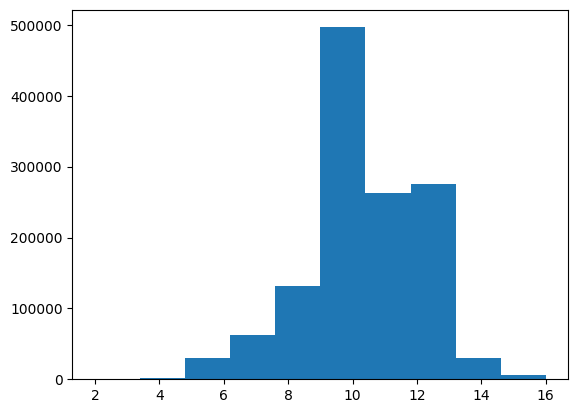

0.19708742882248045
length:  11   ['-f0', 'f1', '-r1', 'f1', 'd1', '-f1', 'r1', 'f1', 'r1', 'f1', 'f1']


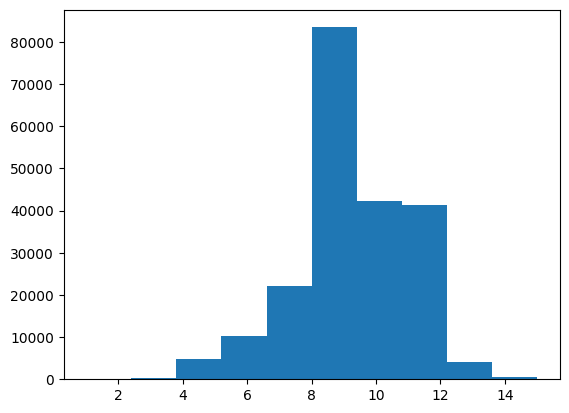

0.26741932662230705
length:  12   ['d1', 'r0', '-d1', 'r1', 'r1', 'd0', 'r1', '-d0', 'f1', 'r0', 'd0', '-r0']


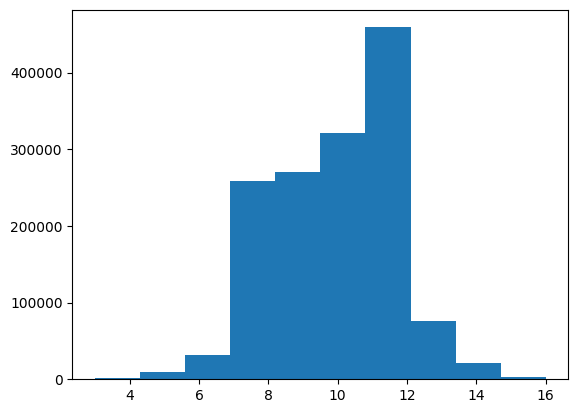

0.18969854378848455
length:  10   ['f0', '-f1', 'd0', 'f0', 'd0', '-r0', '-f1', '-d0', '-f1', 'r0']


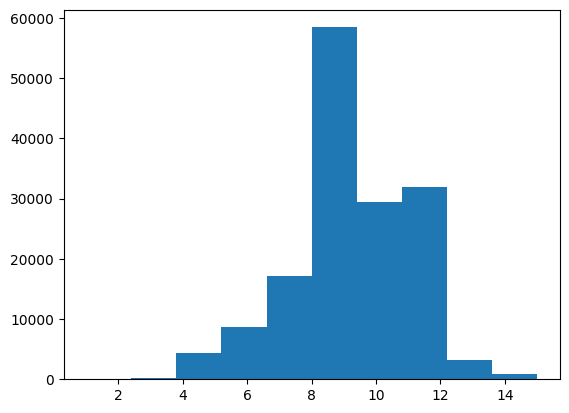

0.18508040500297795
length:  11   ['-f0', '-d0', '-f1', '-r0', '-f1', '-r0', 'd1', 'f1', 'r0', '-f1', '-r0']


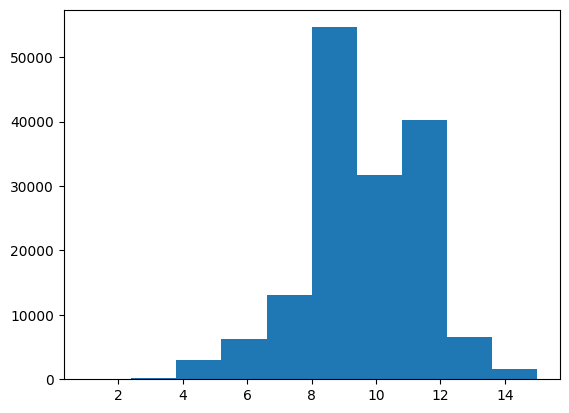

0.2739956943823876
length:  12   ['d0', 'f1', 'd1', 'f1', '-d1', 'f1', '-d1', '-r0', '-r0', 'd1', 'd1', 'r0']


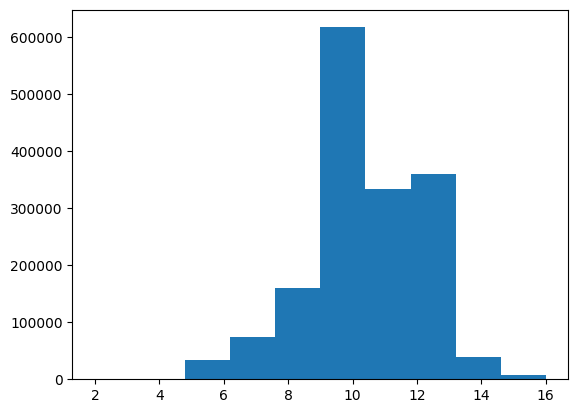

0.2149797249432054
length:  11   ['f1', 'd1', 'f0', 'd1', 'd1', '-r0', '-d1', '-r0', 'd1', 'r0', 'r0']


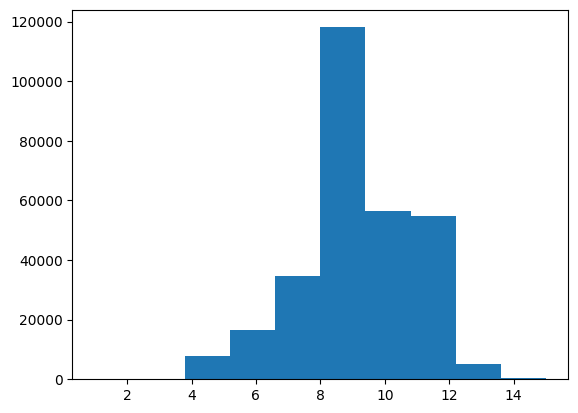

0.25430359071607495
length:  12   ['-f1', '-d0', '-r1', 'd1', '-f0', 'd0', '-f0', '-d0', '-f0', 'd0', '-r0', '-d0']


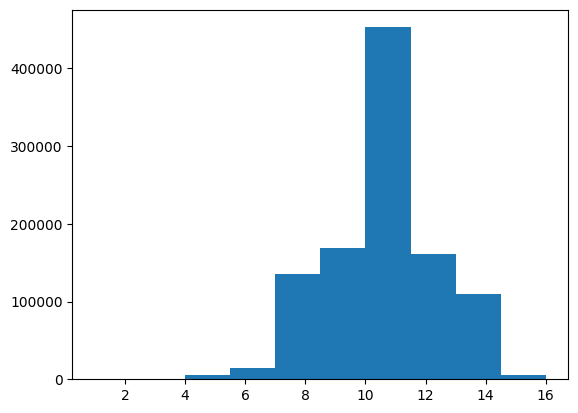

0.255839358085876
length:  12   ['-f0', 'r1', 'd0', 'd0', 'f0', 'r1', 'd1', '-f0', 'd0', '-f0', '-d0', 'f0']


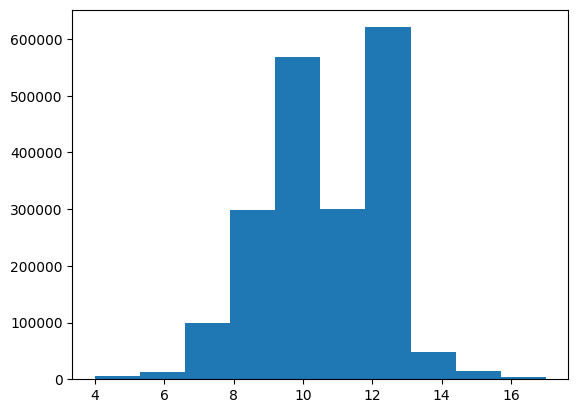

0.3681072776928186
length:  14   ['-f0', '-d0', 'r0', 'd1', 'f0', 'r0', '-d1', '-d1', 'r0', 'r0', '-d1', '-r0', 'd1', 'd1']


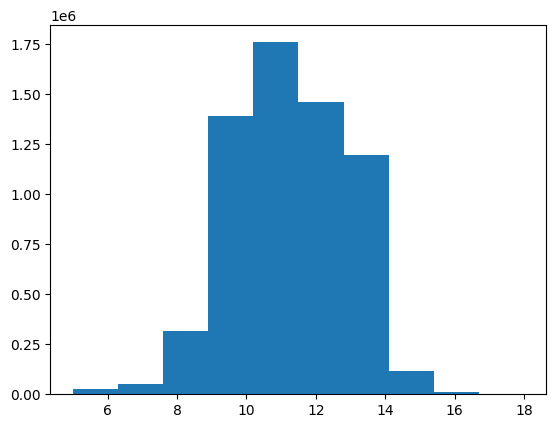

0.27277770676027574
length:  13   ['-f0', 'd0', '-f1', 'd1', 'd1', '-r1', '-f1', 'r1', 'd0', '-r1', '-d0', 'r1', 'r1']


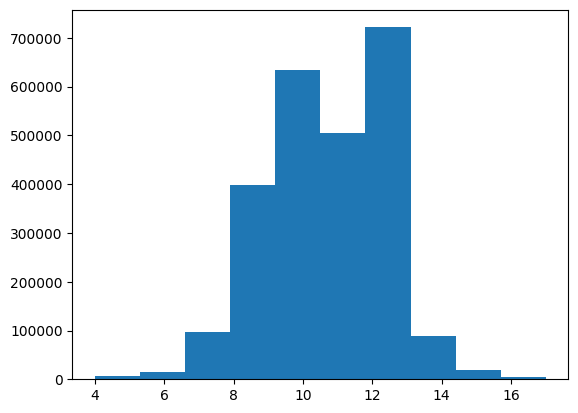

CPU times: user 1min 50s, sys: 3.14 s, total: 1min 53s
Wall time: 1min 41s


In [43]:
%%time
for i in range(0, 23):
    a = solve(i)
    print("length: ", len(a), " ", a)
    fringe_lengths = [] # all path lengths on fringe
    for j in pq:
        fringe_lengths.append(j[3])

    plt.hist(fringe_lengths)
    plt.show()

In [31]:
print(puzzles_df.head())

   id puzzle_type                                   solution_state  \
0   0  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
1   1  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
2   2  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
3   3  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
4   4  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   

                                     initial_state  num_wildcards  \
0  D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C              0   
1  D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C              0   
2  E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D              0   
3  A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E              0   
4  E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A              0   

                                parsed_initial_state  \
0  [0, 1, 0, 2, 1, 3, 2, 3, 4, 2, 4, 2, 0, 4, 0, ...   
1  [0, 1, 4, 3, 3, 1, 5, 2, 5, 0, 3, 5, 5, 1, 3, ...

In [35]:
puzzles_df['parsed_initial_state'][0] = puzzles_df['parsed_solution_state'][0]

puzzles_df['parsed_initial_state'][0][0] = 3
puzzles_df['parsed_initial_state'][0][4] = 2

/var/folders/kd/99328vjn0zlc1kls78_rwvdh0000gn/T/ipykernel_9343/1731516770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puzzles_df['parsed_initial_state'][0] = puzzles_df['parsed_solution_state'][0]


In [36]:
print(puzzles_df.head())

   id puzzle_type                                   solution_state  \
0   0  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
1   1  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
2   2  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
3   3  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
4   4  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   

                                     initial_state  num_wildcards  \
0  D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C              0   
1  D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C              0   
2  E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D              0   
3  A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E              0   
4  E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A              0   

                                parsed_initial_state  \
0  [3, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ...   
1  [0, 1, 4, 3, 3, 1, 5, 2, 5, 0, 3, 5, 5, 1, 3, ...

length:  6   r1.-f1


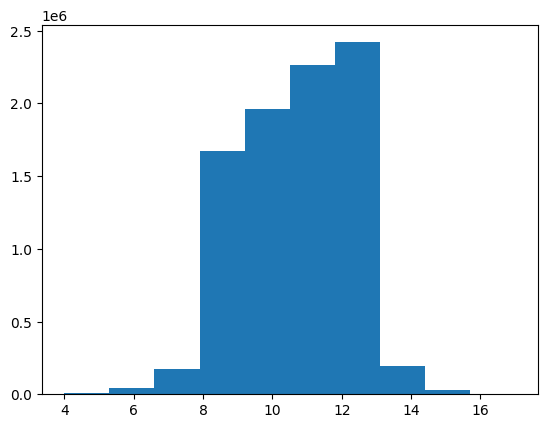

length:  9   ['f0', 'r1', 'f1', '-d0', '-d0', 'f1', '-d0', '-f1', 'd0']


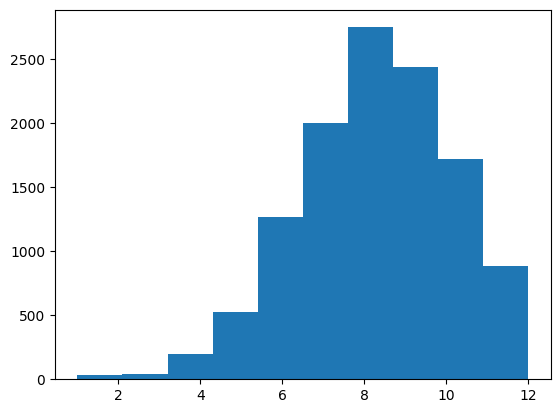

length:  12   ['-f1', '-r0', '-f0', '-r1', '-f0', 'd0', '-r1', '-d0', 'f0', 'd0', 'd0', '-f0']


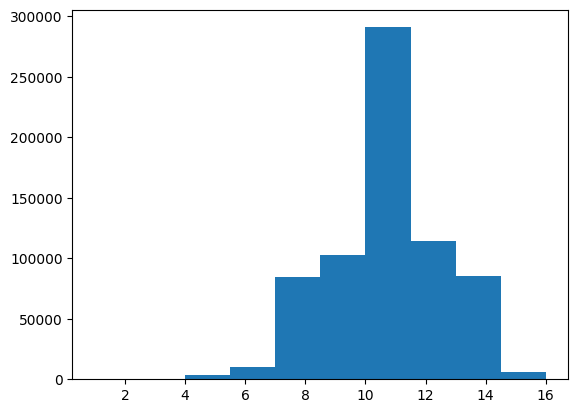

length:  10   ['-f0', 'd0', '-r0', 'f0', '-d0', '-r0', 'd0', '-f0', '-r0', '-f0']


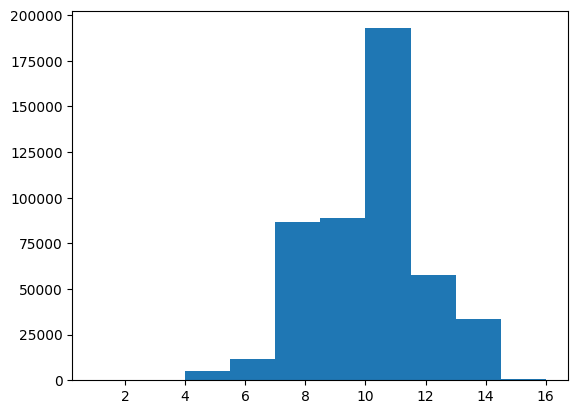

length:  12   ['f0', '-r0', '-f1', '-r0', '-d1', '-r0', '-d1', '-d1', 'r0', 'd0', 'f1', '-d0']


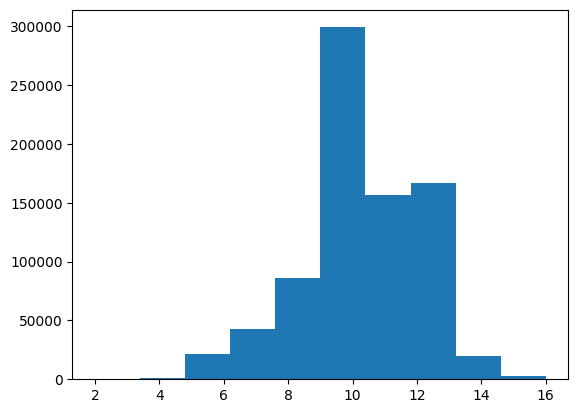

length:  12   ['f0', '-r0', '-f0', '-r0', '-f0', '-f0', '-d1', '-f0', '-d1', '-r0', '-f0', 'r0']


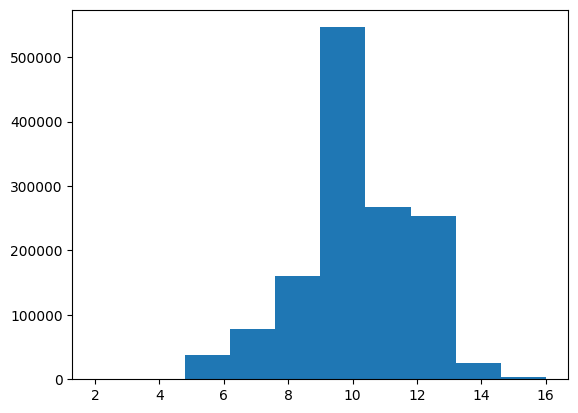

length:  12   ['-r0', 'r1', 'f0', '-r1', 'd1', 'f1', '-d0', 'f0', '-d0', 'f0', 'd0', 'd0']


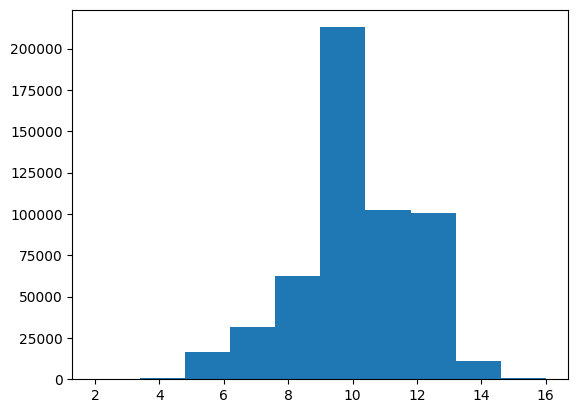

length:  11   ['-f1', '-r0', '-f0', '-d0', '-f1', '-r1', 'd1', '-r1', 'f0', '-d1', '-f0']


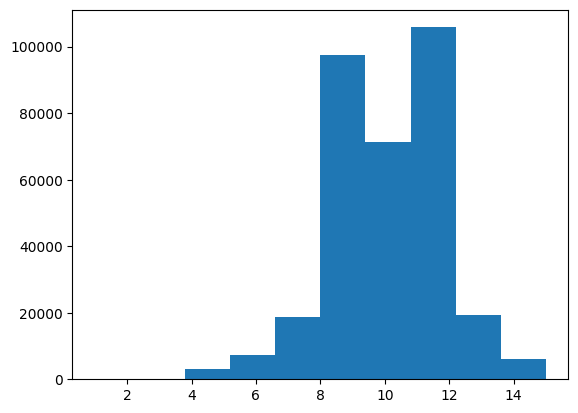

length:  12   ['-d0', '-f0', '-r1', '-d1', '-f0', '-r0', 'f0', 'f0', 'r0', '-f0', '-d1', 'f0']


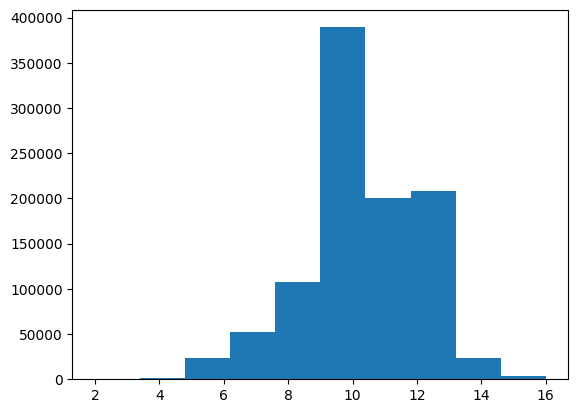

length:  12   ['-d1', 'f1', '-f0', '-r0', 'd0', 'd0', '-r0', '-d0', '-r0', '-f0', 'r0', 'f0']


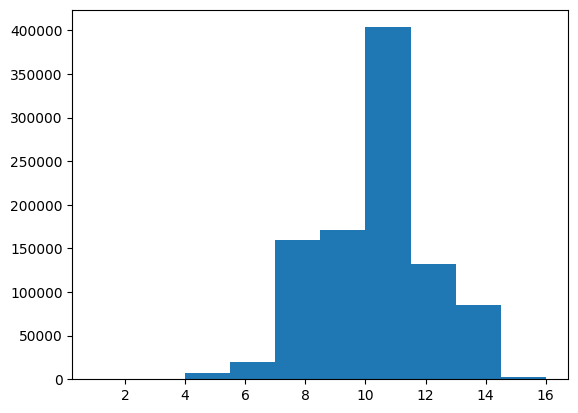

length:  10   ['f0', 'd1', '-r0', 'r1', 'f0', 'd1', '-f0', '-d1', '-d1', '-f0']


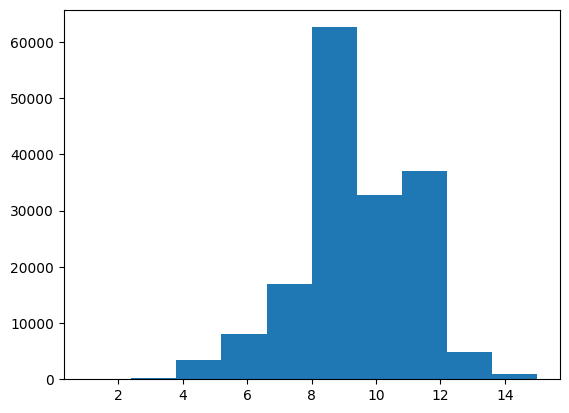

length:  11   ['d0', '-f1', '-d1', 'f0', 'r1', '-d1', 'r0', '-f1', '-d1', '-f1', '-d1']


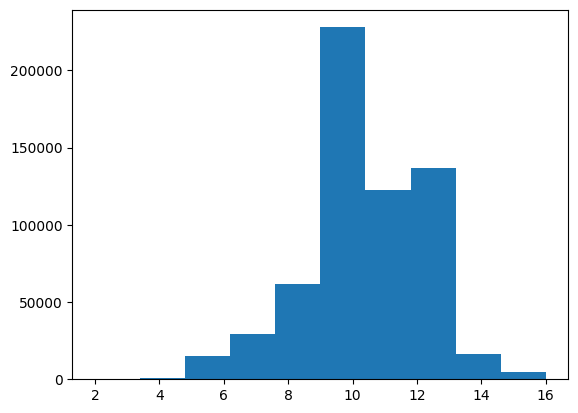

KeyboardInterrupt: 

In [37]:
%%time
for i in range(0, 23):
    a = solve(i)
    print("length: ", len(a), " ", a)
    fringe_lengths = [] # all path lengths on fringe
    for j in pq:
        fringe_lengths.append(j[3])

    plt.hist(fringe_lengths)
    plt.show()

In [49]:
print(np.random.rand())

0.35644587366455527
